DifferentialEquations.jl includes Feagin's explicit Runge-Kutta methods of orders 10/8, 12/10, and 14/12. These methods have such high order that it's pretty much required that one uses numbers with more precision than Float64. As a prerequisite reference on how to use arbitrary number systems (including higher precision) in the numerical solvers, please see the Solving Equations in With Chosen Number Types notebook.

## Investigation of the Method's Error

We can use Feagin's order 16 method as follows. Let's use a two-dimensional linear ODE. Like in the Solving Equations in With Chosen Number Types notebook, we change the initial condition to BigFloats to tell the solver to use BigFloat types.
# Feagin&#39;s Order 10, 12, and 14 Methods
### Chris Rackauckas

In [1]:
using DifferentialEquations
const linear_bigα = big(1.01)
f(u,p,t) = (linear_bigα*u)

# Add analytical solution so that errors are checked
f_analytic(u0,p,t) = u0*exp(linear_bigα*t)
ff = ODEFunction(f,analytic=f_analytic)
prob = ODEProblem(ff,big(0.5),(0.0,1.0))
sol = solve(prob,Feagin14(),dt=1//16,adaptive=false);

In [2]:
println(sol.errors)

Dict(:l∞=>2.19751e-23,:final=>2.19751e-23,:l2=>1.0615e-23)


Compare that to machine $\epsilon$ for Float64:

In [3]:
eps(Float64)

2.220446049250313e-16

The error for Feagin's method when the stepsize is 1/16 is 8 orders of magnitude below machine $\epsilon$! However, that is dependent on the stepsize. If we instead use adaptive timestepping with the default tolerances, we get

In [4]:
sol =solve(prob,Feagin14());
println(sol.errors); print("The length was $(length(sol))")

Dict(:l∞=>1.54574e-09,:final=>1.54574e-09,:l2=>8.92507e-10)
The length was 3

Notice that when the stepsize is much higher, the error goes up quickly as well. These super high order methods are best when used to gain really accurate approximations (using still modest timesteps). Some examples of where such precision is necessary is astrodynamics where the many-body problem is highly chaotic and thus sensitive to small errors.

## Convergence Test

The Order 14 method is awesome, but we need to make sure it's really that awesome. The following convergence test is used in the package tests in order to make sure the implementation is correct. Note that all methods have such tests in place.

In [7]:
using DiffEqDevTools
dts = 1.0 ./ 2.0 .^(10:-1:4)
sim = test_convergence(dts,prob,Feagin14())

┌ Info: Precompiling DiffEqDevTools [f3b72e0c-5b89-59e1-b016-84e28bfd966d]
└ @ Base loading.jl:1186


ConvergenceSimulation{ODESolution{BigFloat,1,Array{BigFloat,1},Array{BigFloat,1},Dict{Symbol,BigFloat},Array{Float64,1},Array{Array{BigFloat,1},1},ODEProblem{BigFloat,Tuple{Float64,Float64},false,Nothing,ODEFunction{false,typeof(f),LinearAlgebra.UniformScaling{Bool},typeof(f_analytic),Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem},Feagin14,OrdinaryDiffEq.InterpolationData{ODEFunction{false,typeof(f),LinearAlgebra.UniformScaling{Bool},typeof(f_analytic),Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{BigFloat,1},Array{Float64,1},Array{Array{BigFloat,1},1},OrdinaryDiffEq.Feagin14ConstantCache{BigFloat,Float64}}}}(ODESolution{BigFloat,1,Array{BigFloat,1},Array{BigFloat,1},Dict{Symbol,BigFloat},Array{Float64,1},Array{Array{BigFloat,1},1},ODEProblem{BigFloat,Tuple{Float64,Float64},false,Nothing,ODEFunction{false,typeof(f),LinearAlgebra.UniformScaling{Bool},typeof(f_analytic),Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothi

For a view of what's going on, let's plot the simulation results.

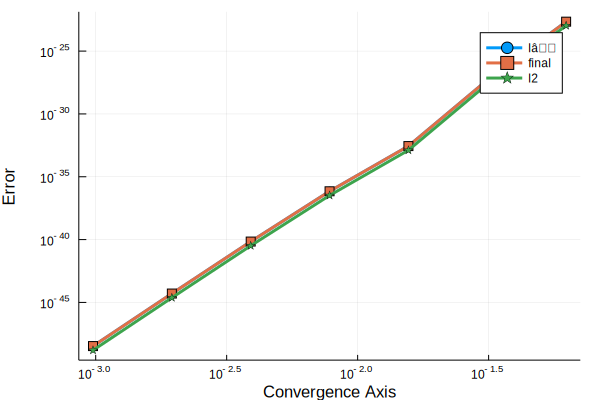

In [8]:
using Plots
gr()
plot(sim)

This is a clear trend indicating that the convergence is truly Order 14, which
is the estimated slope.